# Cloud exponential transformation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import h5py
%cd /global/u2/z/zeyuanhu/nvidia_codes/Climsim_private
from climsim_utils.data_utils import *

/global/homes/z/zeyuanhu/.conda/envs/climsim/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/global/u2/z/zeyuanhu/nvidia_codes/Climsim_private


2024-06-18 11:34:46.475622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 11:34:46.475724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 11:34:46.536857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 11:34:46.685209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 11:34:49.108652: W tensorflow/compiler/tf2

## read the liquid cloud, ice cloud and/or total cloud

In [3]:
# this example here will use read in the training data and read the input cloud liquid/ice.
# we saved the whole unnormalized training data into 14 folder named 11, 12,21,22,...,71,72
# the example below will use half of the training data. The data here basically subsamples the full 7-year training data with a stride of 2.

cases = ['11', '21', '31', '41', '51', '61', '71']

# Initialize an empty list to store data arrays
data_list_liquid = []
data_list_ice = []

# Loop over each data file
for case in cases:
    file_path = f'/global/homes/z/zeyuanhu/scratch/hugging/E3SM-MMF_ne4/preprocessing/v4_full/{case}/train_input.h5'
    with h5py.File(file_path, 'r') as file:
        data_list_liquid.append(file['data'][:, 120:180])
        data_list_ice.append(file['data'][:, 180:240])

# Concatenate all data arrays along the first dimension
xin_liquid = np.concatenate(data_list_liquid, axis=0)
xin_ice = np.concatenate(data_list_ice, axis=0)
xin_total = xin_liquid + xin_ice

## calculate and save exponential parameter

In [5]:
lbd_qc = np.zeros(60)
lbd_qi = np.zeros(60)
lbd_qn = np.zeros(60)

for i in range(60):
    datac = xin_liquid[:,i]
    datai = xin_ice[:,i]
    datan = xin_total[:,i]
    lbd_qc[i] = 1./(datac[datac>1e-7].mean())
    lbd_qi[i] = 1./(datai[datai>1e-7].mean())
    lbd_qn[i] = 1./(datan[datan>1e-7].mean())

/tmp/ipykernel_61631/1480905936.py:9: RuntimeWarning: Mean of empty slice.
  lbd_qc[i] = 1./(datac[datac>1e-7].mean())
/global/homes/z/zeyuanhu/.conda/envs/climsim/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_61631/1480905936.py:10: RuntimeWarning: Mean of empty slice.
  lbd_qi[i] = 1./(datai[datai>1e-7].mean())
/tmp/ipykernel_61631/1480905936.py:11: RuntimeWarning: Mean of empty slice.
  lbd_qn[i] = 1./(datan[datan>1e-7].mean())


In [7]:
lbd_qc[np.isnan(lbd_qc)] = 1e7
lbd_qi[np.isnan(lbd_qi)] = 1e7
lbd_qn[np.isnan(lbd_qn)] = 1e7

In [11]:
fmt = '%.6e'
climsim_path = '/global/u2/z/zeyuanhu/nvidia_codes/climsim_tests'
norm_path = climsim_path+'/normalization/'
np.savetxt(norm_path + '/qc_exp_lambda_large.txt', lbd_qc.reshape(1, -1), fmt=fmt, delimiter=',')
np.savetxt(norm_path + '/qi_exp_lambda_large.txt', lbd_qi.reshape(1, -1), fmt=fmt, delimiter=',')
np.savetxt(norm_path + '/qn_exp_lambda_large.txt', lbd_qn.reshape(1, -1), fmt=fmt, delimiter=',')

Note that in preprocessing/normalizations/inputs/, there the qn_exp_lambda_large.txt was calculated like above, but qi_exp_lambda_large.txt and qc_exp_lambda_large.txt were calculated based on a 7-step-subsampled version of training data and will has slight difference to what is calculated in this notebook. If you want to exactly reproduce our Unet training, simply use the files under preprocessing/normalizations/inputs/

In [8]:
lbd_qn

array([10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        ,  7556905.1099813 ,
        3240294.53811436,  4409304.29170528,  5388911.78320826,
        1414189.69398583,   444847.03675674,   550036.71076073,
         452219.47765234,   243545.07231263,   163264.17204164,
         128850.88117789,   108392.13699281,    96868.6539061 ,
          90154.39383647,    83498.67423248,    76720.52614694,
          70937.79468155,    66821.0327278 ,    63916.46591524,
          61597.41430156,    60417.96523765,    60359.64347926,
          60430.76970212,    59696.934318  ,    58222.94889662,
          56637.11031175,    54844.45378425,    52735.80221775,
          50450.11987115,    47895.00010132,    45134.95219383,
          42075.52757738,    38557.91174999,    34843.47468245,
          31537.88963513,    29179.71520

In [9]:
lbd_qi

array([10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        ,  7556905.1099813 ,
        3240294.53811436,  4409304.29170528,  5388911.78320826,
        1414189.69398583,   444847.03675674,   550036.71076073,
         452219.47765234,   243545.07231263,   163264.17204164,
         128850.88117789,   108392.13699281,    96868.6539061 ,
          90154.39383647,    83498.67423248,    76720.52614694,
          70937.87706283,    66851.27198026,    64579.78345685,
          64987.05874437,    68963.77227883,    75498.91605962,
          82745.37660119,    89624.52634008,    96373.41157796,
         102381.42808207,   102890.33417304,    96849.77123401,
          92727.78368907,    91320.9721545 ,    91240.30382044,
          91448.65004889,    91689.26513737,    91833.1829058 ,
          91941.15859653,    92144.10295

In [10]:
lbd_qc

array([10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        , 10000000.        ,
       10000000.        , 10000000.        ,  2410793.53754872,
        3462644.65436088,  1594172.20270602,   328086.13752288,
         154788.55435228,   118712.37335602,   104208.42410058,
          95801.11739569,    89619.52961093,    83709.51800851,
          78846.75613935,    74622.76219094,    70555.95112947,
          66436.67119096,    61797.61126943,    56926.03823691,
          51838.00818631,    46355.21691466,    40874.23574077,
          36196.39550842,    32935.40953

## More visualization on the exponential transformation

We will transform cloud feature through qc’ = 1 - exp(-qc * 𝜆). 𝜆 is the exponential parameter, estimated as 1/(data[data>threshold].mean()). If input feature is indeed a exponential distribution, then this transformation will convert it to a uniform distribution between (0,1). In the calculation above, we have a threshold=1e-7 to select only the cloudy grids that has non-trivial amount of cloud mass. Below is a visualization of cloud feature distribution before and after transformation.


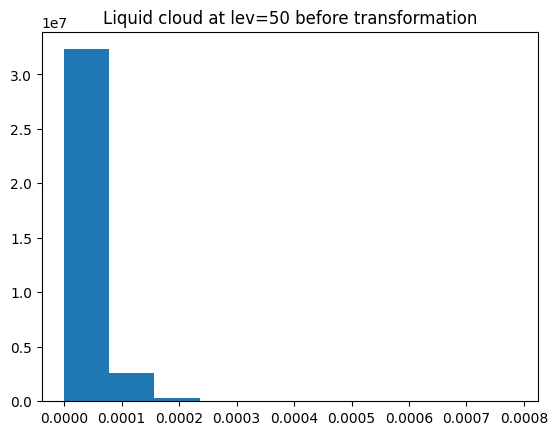

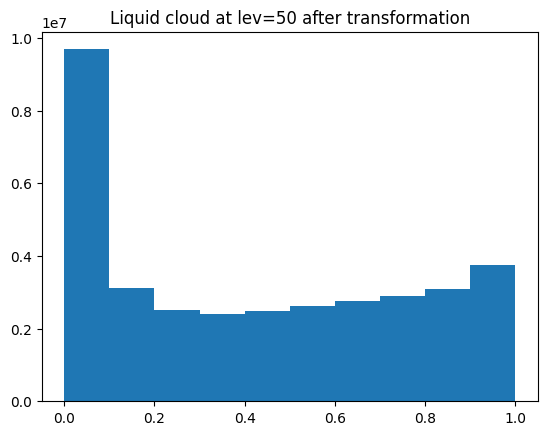

In [13]:
# take liquid cloud at level 50 for example
qc = xin_liquid[:,50]
qc_trans = 1 - np.exp(-qc * lbd_qc[50])
plt.hist(qc)
plt.title(f'Liquid cloud at lev=50 before transformation')
plt.show()

plt.hist(qc_trans)
plt.title(f'Liquid cloud at lev=50 after transformation')
plt.show()